In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

In [2]:
TrainMat = np.load('TrainDigits.npy')
TrainLabel = np.load('TrainLabels.npy')
TestMat = np.load('TestDigits.npy')
TestLabel = np.load('TestLabels.npy')

In [3]:
print("TrainMat shape:", TrainMat.shape)
print("TrainLabel shape:", TrainLabel.shape)
print("TestMat shape:", TestMat.shape)
print("TestLabel shape:", TestLabel.shape)

TrainMat shape: (784, 240000)
TrainLabel shape: (1, 240000)
TestMat shape: (784, 40000)
TestLabel shape: (1, 40000)


In [5]:
def sort_function(i, TrainLabel, TrainMat):
    # Flatten the TrainLabel array
    flattened_list = np.ndarray.flatten(TrainLabel)
    
    # Initialize an empty matrix with shape (784, 0)
    num_matrix = np.empty((784, 0))
    
    # Counter to track the number of columns added
    n = 0
    
    # Loop through indices where the flattened list equals the given i
    for num in np.argwhere(flattened_list == i).flatten():
        if n < 2000:
            # Extract the column to add from TrainMat
            column_to_add = TrainMat[:, num].reshape(-1, 1)
            
            # Horizontally stack the new column to the num_matrix
            num_matrix = np.hstack((num_matrix, column_to_add))
            
            # Increment the counter
            n += 1
    
    # Convert the matrix to float32 type
    num_matrix = num_matrix.astype(np.float32)
    
    return num_matrix

In [6]:
def plot_digit_3_and_8_function(TrainLabel, TrainMat):
    # Get the sorted matrices for digits 3 and 8
    A3 = sort_function(3, TrainLabel, TrainMat)
    A8 = sort_function(8, TrainLabel, TrainMat)
    
    # Perform Singular Value Decomposition (SVD) on the matrices
    U3, S3, Vt3 = np.linalg.svd(A3)
    U8, S8, Vt8 = np.linalg.svd(A8)
    
    # Prepare the x-axis values (0 to 783)
    x = list(range(784))
    
    # Prepare the y-axis values for singular values
    y3 = list(S3)
    y8 = list(S8)
    
    # Create subplots for the singular values
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    axes[0].scatter(x, y3)
    axes[0].set_title('Number 3 Singular Values')
    
    axes[1].scatter(x, y8)
    axes[1].set_title('Number 8 Singular Values')
    
    # Create subplots for the reshaped vectors
    fig, axarr = plt.subplots(2, 3, figsize=(10, 8))
    
    # Reshape the vectors to 28x28 matrices and transpose
    D1 = np.reshape(U3[:, 0], (28, 28)).T
    D2 = np.reshape(U3[:, 1], (28, 28)).T
    D3 = np.reshape(U3[:, 2], (28, 28)).T
    
    D4 = np.reshape(U8[:, 0], (28, 28)).T
    D5 = np.reshape(U8[:, 1], (28, 28)).T
    D6 = np.reshape(U8[:, 2], (28, 28)).T
    
    # Display the reshaped matrices
    axarr[0, 0].imshow(D1, cmap='gray')
    axarr[0, 0].set_title('U3[:, 0]')
    
    axarr[0, 1].imshow(D2, cmap='gray')
    axarr[0, 1].set_title('U3[:, 1]')
    
    axarr[0, 2].imshow(D3, cmap='gray')
    axarr[0, 2].set_title('U3[:, 2]')
    
    axarr[1, 0].imshow(D4, cmap='gray')
    axarr[1, 0].set_title('U8[:, 0]')
    
    axarr[1, 1].imshow(D5, cmap='gray')
    axarr[1, 1].set_title('U8[:, 1]')
    
    axarr[1, 2].imshow(D6, cmap='gray')
    axarr[1, 2].set_title('U8[:, 2]')
    
    plt.show()

In [7]:
def plot_function(Uk):
    # Reshape the first column of Uk to a 28x28 matrix and transpose it
    D = np.reshape(Uk[:, 0], (28, 28)).T
    
    # Display the matrix as a grayscale image
    plt.imshow(D, cmap='gray')
    plt.title('Digit Representation')
    plt.axis('off')  # Hide the axis for better visualization
    plt.show()

In [8]:
def plot_all_digits(digit_dict):
    # Create subplots with 1 row and 10 columns
    fig, axarr = plt.subplots(1, 10, figsize=(15, 3))
    
    for i in range(10):
        # Reshape the first column of each digit's matrix to a 28x28 matrix and transpose it
        D = np.reshape(digit_dict[i][:, 0], (28, 28)).T
        # Display the reshaped matrix as a grayscale image
        axarr[i].imshow(D, cmap='gray')
        axarr[i].axis('off')  # Hide the axis for better visualization
        axarr[i].set_title(f'Digit {i}', fontsize=10)  # Add title for each subplot
    
    plt.show()

In [11]:
def Compute_SVD(M):
    return np.linalg.svd(M, full_matrices=False)

In [12]:
def Compute_UK(k, TrainLabel, TrainMat):
    uk_dict = {}
    projection_dict = {}
    
    for num in range(10):
        # Compute the SVD of the sorted function's result
        U, S, Vt = Compute_SVD(sort_function(num, TrainLabel, TrainMat))
        
        # Get the first k columns of U
        U_k = U[:, :k]
        uk_dict[num] = U_k
        
        # Compute the orthogonal projection matrix
        U_kt = U_k.T
        projection_matrix = np.identity(784) - (U_k @ U_kt)
        projection_dict[num] = projection_matrix
    
    return projection_dict

In [18]:
def compute_residual(k, TestMat, TestLabel, TrainLabel, TrainMat):
    # Initialize counters
    correct_predictions = 0
    digit_counts = {i: 0 for i in range(10)}
    correct_digit_counts = {i: 0 for i in range(10)}

    # Compute the projection matrices for each digit
    Uk_Ukt = Compute_UK(k, TrainLabel, TrainMat)

    # Loop through each sample in the test set
    for x in range(40000):
        # Calculate the residuals for the current sample
        residuals = [np.linalg.norm(Uk_Ukt[key] @ TestMat[:, x]) for key in Uk_Ukt]
        
        # Find the minimum residual and the corresponding expected number
        residual_min = min(residuals)
        expected_number = residuals.index(residual_min)

        # Update counters
        actual_number = TestLabel[0][x]
        if expected_number == actual_number:
            correct_predictions += 1
            correct_digit_counts[actual_number] += 1
        digit_counts[expected_number] += 1

    # Calculate total accuracy
    total_percentage = (correct_predictions / 40000) * 100
    print(f'Accuracy: {total_percentage:.2f}%')

    # Calculate and print the accuracy for each digit
    for digit in range(10):
        digit_accuracy = (correct_digit_counts[digit] / 4000) * 100
        print(f'Percentage of correct {digit} with k={k}: {digit_accuracy:.2f}%')

    return correct_predictions, correct_digit_counts

In [21]:
compute_residual(15, TestMat, TestLabel, TrainLabel, TrainMat)

Accuracy: 95.24%
Percentage of correct 0 with k=15: 98.15%
Percentage of correct 1 with k=15: 98.70%
Percentage of correct 2 with k=15: 95.88%
Percentage of correct 3 with k=15: 94.88%
Percentage of correct 4 with k=15: 95.23%
Percentage of correct 5 with k=15: 92.40%
Percentage of correct 6 with k=15: 96.90%
Percentage of correct 7 with k=15: 95.38%
Percentage of correct 8 with k=15: 90.97%
Percentage of correct 9 with k=15: 93.95%


(38097,
 {0: 3926,
  1: 3948,
  2: 3835,
  3: 3795,
  4: 3809,
  5: 3696,
  6: 3876,
  7: 3815,
  8: 3639,
  9: 3758})

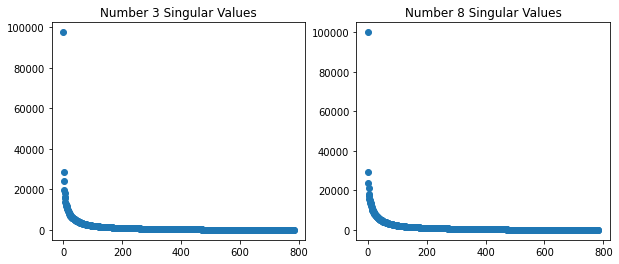

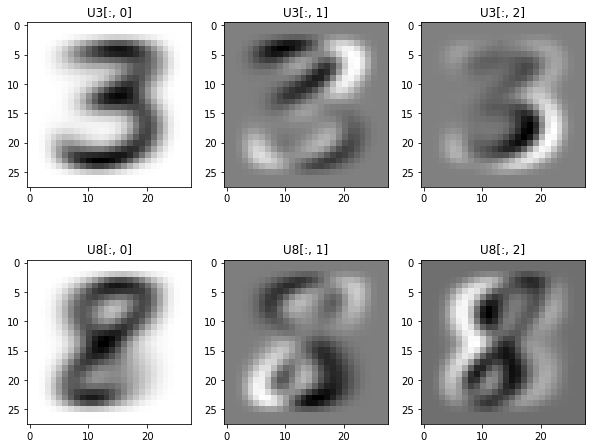

In [20]:
plot_digit_3_and_8_function(TrainLabel, TrainMat)